In [1]:
from dlem import load_reader, load_model
import matplotlib.pyplot as plt
import numpy as np
from dlem.feature_extraction import extractor
from dlem import util
from dlem.util import diagonal_normalize
import pandas as pd
import pyBigWig
from tqdm import tqdm
from typing import Optional, Sized, Iterator
import torch

In [2]:
res = 1000
#window_size = 2000000//res
window_size = 1000000//res
stride = 150

In [3]:
data = load_reader("datareader_cooler")(
    "../../../loopExtraction/data/4DNFI9GMP2J8.mcool",
    res,
    window_size,
    stride,
    chrom_subset=["chr10"],
    return_raw=True
)

In [4]:
data_normalized = load_reader("datareader_cooler")(
    "../../../loopExtraction/data/4DNFI9GMP2J8.mcool",
    res,
    window_size,
    stride,
    chrom_subset=["chr10"],
)

In [5]:
np.isnan(data[0][0].numpy()).any()

False

/tmp/ipykernel_1214896/913637599.py:1: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(data[0][0].numpy()))


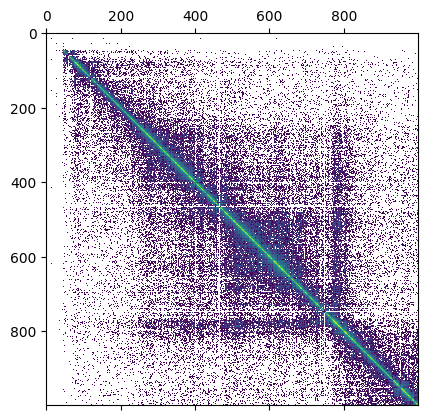

In [6]:
plt.matshow(np.log(data[0][0].numpy()))

In [7]:
data[0][0].diag(1)

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   4.,  11.,  94.,
        172., 121.,  85.,  91.,  25.,  10.,  45.,  27.,  31.,  45.,  41.,   6.,
          1.,  18.,  31.,  82., 120., 104.,  77., 133., 111.,  44., 167., 118.,
         58., 148., 194., 203., 138., 155., 448., 772., 557., 500., 492., 552.,
        814., 691., 557., 659., 417., 169., 318., 542., 184.,  97., 145., 182.,
        205., 211., 296., 273., 184., 200., 162., 454., 559., 211., 233., 177.,
        146., 190., 173., 242., 250., 172., 133., 250., 121.,  93.,  14.,   8.,
         13.,  28., 130., 114., 168., 185., 153., 110., 162., 270., 370., 252.,
        207., 155.,  60., 120., 232., 141., 159., 129., 111., 171., 193., 150.,
        106., 134., 190., 235., 161.,  4

In [8]:
from dlem import loss

In [9]:
loss_fn = loss.DirectMultinomialNLLLoss1D()

In [10]:
probs = np.random.rand(data[0][0].diag(6).shape[0])
probs = probs / probs.sum()

In [11]:
probs

array([1.18048029e-03, 1.64092460e-03, 1.09348844e-03, 1.58428477e-03,
       1.85332100e-03, 3.12320231e-04, 1.27077330e-03, 1.10254074e-03,
       1.58277403e-03, 3.38722275e-05, 6.71022763e-04, 3.16997096e-04,
       1.88670149e-03, 1.41619974e-03, 1.37409466e-03, 1.26379096e-03,
       1.96561604e-03, 4.04578528e-04, 8.06906692e-04, 1.82045363e-03,
       1.21883672e-03, 1.30359869e-03, 6.20315684e-04, 1.57561713e-03,
       1.83357180e-03, 9.60678795e-04, 1.87245531e-03, 6.70640373e-04,
       1.24177880e-03, 1.47502131e-03, 1.55613123e-03, 1.69017418e-03,
       2.29303109e-04, 1.61705841e-03, 3.79246110e-04, 1.17609522e-05,
       3.00663796e-04, 1.96092201e-03, 1.41522775e-03, 1.92231399e-03,
       8.20732850e-04, 4.29967576e-04, 8.53454115e-04, 6.01977057e-04,
       1.79620987e-03, 3.42161410e-04, 2.82906289e-04, 4.34319161e-05,
       8.67419932e-04, 7.56655154e-04, 5.20839600e-04, 7.87238384e-04,
       3.30557058e-04, 9.01317459e-04, 3.84238683e-04, 6.74030527e-04,
      

In [12]:
loss_fn(torch.from_numpy(probs), data[0][0].diag(6))

tensor(-122607.9300, dtype=torch.float64)

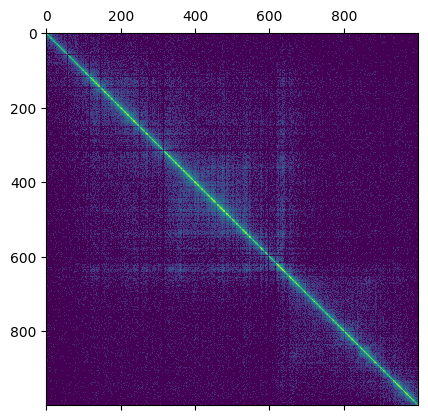

In [13]:
plt.matshow(torch.log1p(data[1][0]))

In [14]:
dev = torch.device("cuda:0")

In [15]:
patch = data[1][0].unsqueeze(0).to(dev) + 1

In [16]:
patch_normalized = data_normalized[1][0].unsqueeze(0)

In [17]:
init_diag = torch.ones((patch.shape[0], patch.shape[1])) * patch.shape[1]
init_diag = init_diag.to(dev)

In [18]:
best_corr = -torch.inf
arr_corr = []
best_loss = torch.inf
arr_loss = []

In [19]:
diag_start, diag_end = 0, 1500

In [20]:
model = load_model("netdlem2")(patch.shape[1])
model = model.to(dev)

In [21]:
train_ii = util.diagonal_region_indices_from(patch, diag_start, diag_end)

In [22]:
num_epoch = 1000

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [24]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, mode="max")

In [25]:
early_thresh = 0.00001

In [26]:
patch.shape

torch.Size([1, 1000, 1000])

In [27]:
loss_fn = loss.DirectMultinomialNLLLoss1D()

In [28]:
pred = model(util.get_diags(patch, 1), 1, False)

In [35]:
patch = torch.exp(util.diagonal_normalize(torch.log(patch_normalized.to(dev))))

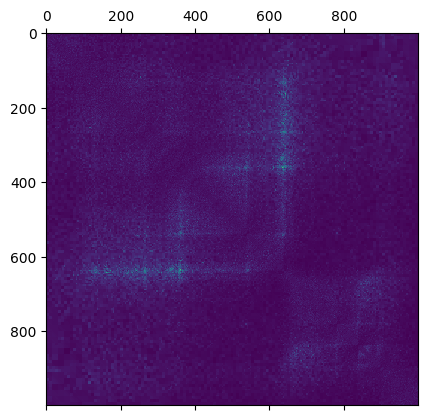

In [36]:
plt.matshow(patch.detach().cpu().numpy()[0])

In [38]:
patch.min()

tensor(0.1214, device='cuda:0')

In [39]:
patch.max()

tensor(20.3955, device='cuda:0')

In [40]:
pred

tensor([], device='cuda:0', size=(1, 0), grad_fn=<LogBackward0>)

In [42]:
util.get_diags(patch, 500)

tensor([[0.3963, 0.3963, 0.3963, 0.3963, 0.7253, 0.7253, 0.7253, 0.7253, 0.4266,
         0.4266, 0.4266, 0.4266, 0.7680, 0.7680, 0.7680, 0.7680, 0.6849, 0.6849,
         0.6849, 0.6849, 0.9838, 0.9838, 0.9838, 0.9838, 1.0408, 1.0408, 1.0408,
         1.0408, 0.8373, 0.8373, 0.8373, 0.8373, 1.1152, 1.1152, 1.1152, 1.1152,
         1.0910, 1.0910, 1.0910, 1.0910, 0.4778, 0.4778, 0.4778, 0.4778, 0.8095,
         0.8095, 0.8095, 0.8095, 1.3400, 1.3400, 1.3400, 1.3400, 0.7787, 0.7787,
         0.7787, 0.7787, 1.0893, 1.0893, 1.0893, 1.0893, 0.9008, 0.9008, 0.9008,
         0.9008, 0.8007, 0.8007, 0.8007, 0.8007, 1.3340, 1.3340, 1.3340, 1.3340,
         1.3219, 1.3219, 1.3219, 1.3219, 1.4294, 1.4294, 1.4294, 1.4294, 0.8649,
         0.8649, 0.8649, 0.8649, 1.4940, 1.4940, 1.4940, 1.4940, 1.0643, 1.0643,
         1.0643, 1.0643, 0.9035, 0.9035, 0.9035, 0.9035, 1.9029, 1.7744, 1.6459,
         1.5173, 1.3888, 1.3888, 1.3888, 1.3888, 1.2593, 1.2593, 1.2593, 1.2593,
         2.4185, 2.4185, 2.4

In [41]:
torch.log(model(util.get_diags(patch, 500), 500, False))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [37]:
for e in range(num_epoch):
    #curr_lr = scheduler.get_last_lr()[-1]
    #if curr_lr < early_thresh:
    #    break
    optimizer.zero_grad()
    loss_total = 0
    #pred_map = model.contact_map_prediction(init_diag)
    #pred_map = torch.exp(diagonal_normalize(torch.log(pred_map)))
    #curr_cor = util.mat_corr(pred_map[train_ii], patch[train_ii])
    #arr_corr.append(curr_cor.detach().cpu().numpy())
    for diag_i in range(diag_start, diag_end):
        pred = torch.log(model(util.get_diags(patch, diag_i), diag_i, False))
        loss_total += loss_fn(pred - torch.logsumexp(pred, dim=1), util.get_diags(patch, diag_i+1))
    loss_total = loss_total / (diag_end - diag_start)
    if loss_total < best_loss:
        best_loss = loss_total
        best_loss_model = model.state_dict()
    #if curr_cor > best_corr:
    #    best_corr = curr_cor
    #    best_corr_model = model.state_dict()
    loss_total.backward()
    optimizer.step()
    arr_loss.append(loss_total.detach().cpu().numpy())
    #scheduler.step(curr_cor)

    model.project_to_constraints(1e-5, 1.0-1e-5)
    print(f'{int((e+1)/num_epoch*100):3}/100: '
#        f'correlation = {curr_cor:.3f}, '
        f'loss = {loss_total:.3f}',
            flush=True, end='\r')

KeyboardInterrupt: 

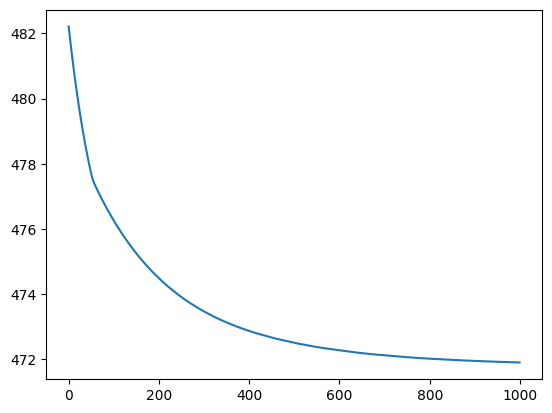

In [ ]:
plt.plot(arr_loss)

In [ ]:
model.load_state_dict(best_loss_model)

<All keys matched successfully>

In [ ]:
pred_map = model.contact_map_prediction(init_diag)

In [ ]:
pred_map.shape

torch.Size([1, 1000, 1000])

In [ ]:
diag_end

1500

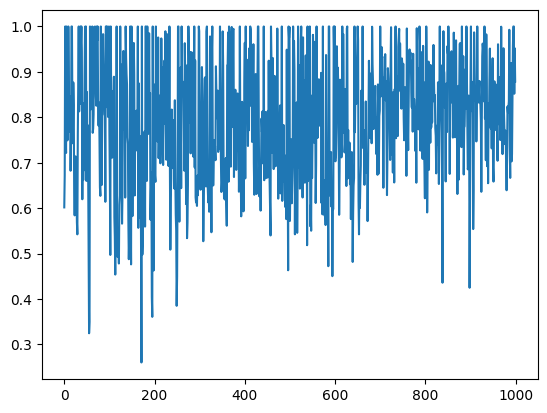

In [ ]:
plt.plot(model.return_parameters()[0])

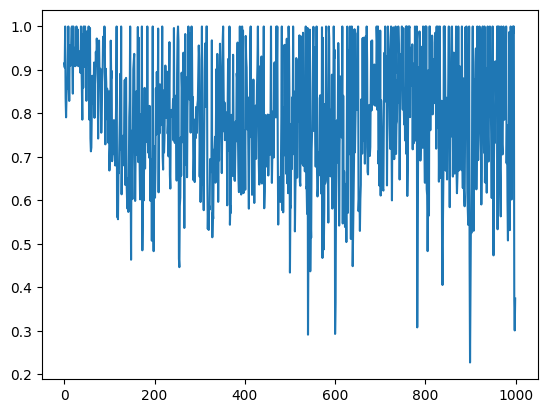

In [ ]:
plt.plot(model.return_parameters()[1])

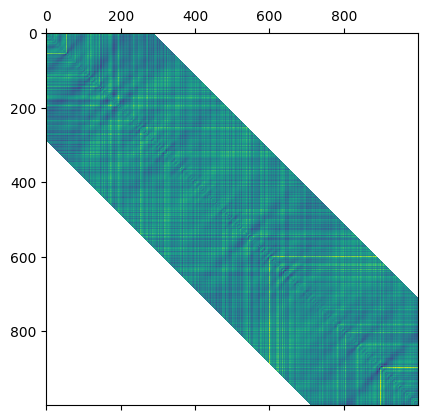

In [ ]:
plt.matshow(util.diagonal_normalize(np.log1p(pred_map.detach().cpu().numpy()))[0])

In [ ]:
patch_normalized = util.diagonal_normalize(np.log(patch_normalized))[0]

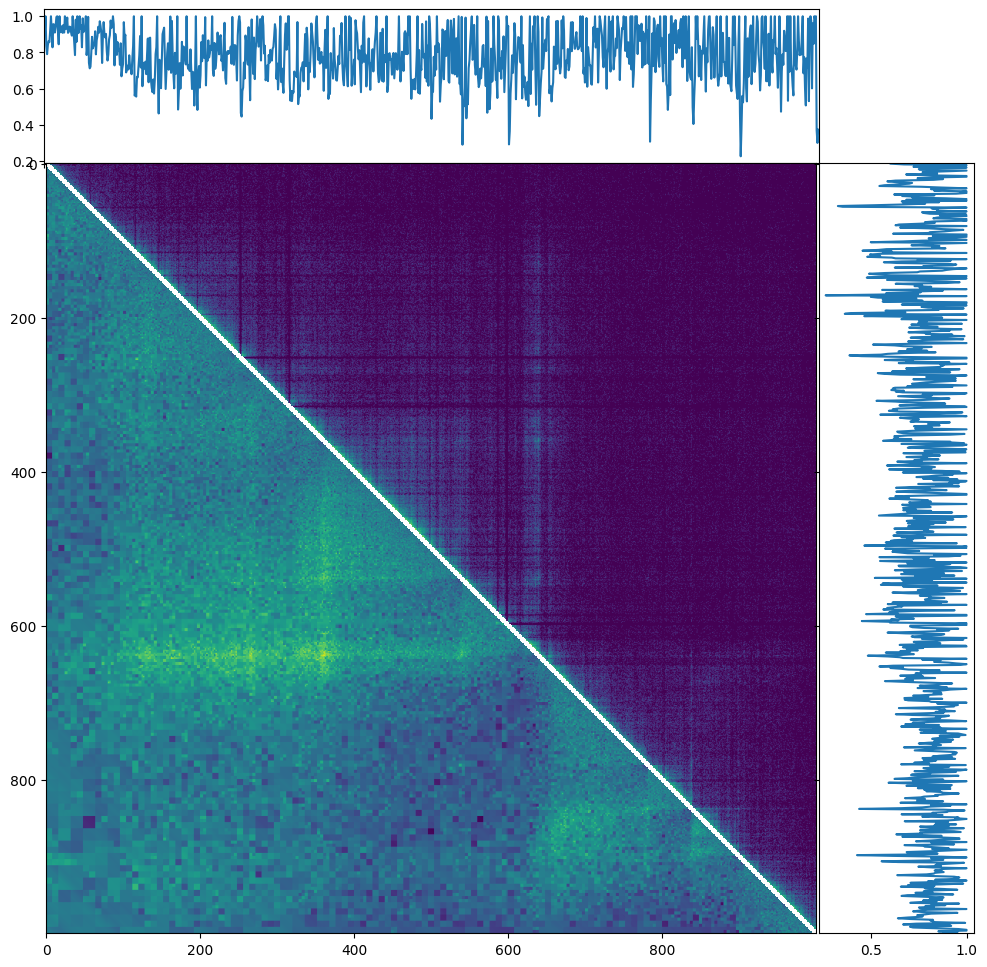

In [ ]:
util.plot_results(np.log1p(patch[0].detach().cpu().numpy()),
                patch_normalized,
                  model.return_parameters(),
                  ignore_i_off=1500)